Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# MNIST Training on ASH cluster and storage account



## Prerequisite

*     A Kubernetes cluster deployed on Azure Stack Hub, connected to Azure through ARC.
     
   For details on how to deploy kubernetes cluster on Azure Stack Hub and enabling ARC connection to Azure, please follow [this guide](https://github.com/Azure/AML-Kubernetes/blob/master/docs/ASH/AML-ARC-Compute.md)
  

*     Datastore setup in Azure Machine Learning workspace backed up by Azure Stack Hub storage account.

   [This document](https://github.com/Azure/AML-Kubernetes/blob/master/docs/ASH/Train-AzureArc.md) is a detailed guide on how to create Azure Machine Learning workspace, create a  Azure Stack Hub Storage account, and setup datastore in AML workspace backed by ASH storage account.


*      Last but not least, you need to be able to run a Notebook. 

   If you are using an Azure Machine Learning Notebook VM, you are all set. Otherwise, make sure you go through the configuration Notebook located at [here](https://github.com/Azure/MachineLearningNotebooks) first if you haven't. This sets you up with a working config file that has information on your workspace, subscription id, etc.

### Setting up AML Workspace

In [1]:
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core import Workspace
import numpy as np

ws = Workspace.from_config()
print("Found workspace {} at location {}".format(ws.name, ws.location))

Failure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azureml.train.hyperdrive:HyperDriveRun._from_run_dto with exception (azureml-telemetry 1.19.0 (c:\users\v-songshanli\anaconda3\envs\pythonproject\lib\site-packages), Requirement.parse('azureml-telemetry~=1.18.0')).
Failure while loading azureml_run_type_providers. Failed to load entrypoint automl = azureml.train.automl.run:AutoMLRun._from_run_dto with exception (azureml-dataset-runtime 1.19.0.post1 (c:\users\v-songshanli\anaconda3\envs\pythonproject\lib\site-packages), Requirement.parse('azureml-dataset-runtime~=1.18.0')).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.PipelineRun = azureml.pipeline.core.run:PipelineRun._from_dto with exception (azureml-core 1.19.0 (c:\users\v-songshanli\anaconda3\envs\pythonproject\lib\site-packages), Requirement.parse('azureml-core~=1.18.0')).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.

Found workspace sl-ash2-mal at location eastus


In [2]:
from azureml.core import Workspace, Dataset, Datastore

dataset_name = "mnist_ash"
if dataset_name not  in ws.datasets:
    
    datastore_name = "ashstore"
    datastore =  Datastore.get(ws, datastore_name)
    
    src_dir, target_path = 'mnist_data', 'mnistdataash'
    datastore.upload(src_dir, target_path)

    # register data uploaded as AML dataset
    datastore_paths = [(datastore, target_path)]
    pd_ds = Dataset.File.from_files(path=datastore_paths)
    pd_ds.register(ws, dataset_name, "mnist data from http://yann.lecun.com/exdb/mnist/")

### Attaching ASH Cluster to AML Workspace

In [3]:
from azureml.contrib.core.compute.arckubernetescompute import ArcKubernetesCompute

resource_id = "/subscriptions/6b736da6-3246-44dd-a0b8-b5e95484633d/resourceGroups/AML-stack-val/providers/Microsoft.Kubernetes/connectedClusters/kub-orlando-Test"

attach_config = ArcKubernetesCompute.attach_configuration(
    resource_id= resource_id,
)

try:
    attach_name = "peymanarc"
    arcK_target_result = ArcKubernetesCompute.attach(ws, attach_name, attach_config)
    arcK_target_result.wait_for_completion(show_output=True)
    print('arc attach  success')
except ComputeTargetException as e:
    print(e)
    print('arc attach  failed')

from azureml.core import ComputeTarget
    
attach_name = "nc6"#"ds3v2" 
arcK_target = compute = ComputeTarget(ws, "nc6") #ws.compute_targets[attach_name]

SucceededProvisioning operation finished, operation "Succeeded"
arc attach  success


### Setting Up AML Experiment and Enviroment

In [4]:
from azureml.core import Experiment

experiment_name = 'mnist-demo'

exp = Experiment(workspace=ws, name=experiment_name)

In [5]:
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

# to install required packages
env = Environment('tutorial-env')
cd = CondaDependencies.create(pip_packages=['azureml-dataset-runtime[pandas,fuse]', 'azureml-defaults'], conda_packages = ['scikit-learn==0.22.1'])

env.python.conda_dependencies = cd

In [6]:
from azureml.core import ScriptRunConfig

args = ['--data-folder', ws.datasets[dataset_name].as_mount(), '--regularization', 0.5]
script_folder =  "mnist_script"
src = ScriptRunConfig(source_directory=script_folder,
                      script='train.py', 
                      arguments=args,
                      compute_target=arcK_target,
                      environment=env)

### Submit Work to AML

In [7]:
run = exp.submit(config=src)
run.wait_for_completion(show_output=True)  # specify True for a verbose log

RunId: mnist-demo_1613157733_4f9fe743
Web View: https://ml.azure.com/experiments/mnist-demo/runs/mnist-demo_1613157733_4f9fe743?wsid=/subscriptions/6b736da6-3246-44dd-a0b8-b5e95484633d/resourcegroups/sl-ash2/workspaces/sl-ash2-mal

Streaming azureml-logs/65_job_prep-tvmps_5687a1ad14a63df82fa31868e83f7a4d61d499d92145788038d808e51395e32f_d.txt

[2021-02-12T19:25:54.722122] Entering job preparation.
[2021-02-12T19:25:55.409017] Starting job preparation.
[2021-02-12T19:25:55.409053] Extracting the control code.
[2021-02-12T19:25:55.427270] fetching and extracting the control code on master node.
[2021-02-12T19:25:55.427296] Starting extract_project.
[2021-02-12T19:25:55.427331] Starting to extract zip file.
[2021-02-12T19:25:56.104148] Finished extracting zip file.
[2021-02-12T19:25:56.238548] Using urllib.request Python 3.0 or later
[2021-02-12T19:25:56.238610] Start fetching snapshots.
[2021-02-12T19:25:56.238651] Start fetching snapshot.
[2021-02-12T19:25:56.238668] Retrieving project f

{'runId': 'mnist-demo_1613157733_4f9fe743',
 'target': 'nc6',
 'status': 'Completed',
 'startTimeUtc': '2021-02-12T19:25:26.748252Z',
 'endTimeUtc': '2021-02-12T19:36:01.743661Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '67528bd0-1a8f-4239-8b9d-b50b5e2973a8',
  'azureml.git.repository_uri': 'git@github.com:lisongshan007/AML-Kubernetes.git',
  'mlflow.source.git.repoURL': 'git@github.com:lisongshan007/AML-Kubernetes.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': 'ee38c6a3ae3decfc757ed35dc478fece1bd83dc0',
  'mlflow.source.git.commit': 'ee38c6a3ae3decfc757ed35dc478fece1bd83dc0',
  'azureml.git.dirty': 'True',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': 'aac6a1a6-8a04-4429-afb7-84c47b4df152'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__16a468c6', 'mechanism': 'Mo

### Register Model

In [8]:
# register model
model = run.register_model(model_name='sklearn_mnist',
                           model_path='outputs/sklearn_mnist_model.pkl')

### Test Model

In [9]:
from azureml.core import Environment, Workspace, Model, ComputeTarget
from azureml.core.compute import AksCompute
from azureml.core.model import InferenceConfig
from azureml.core.webservice import Webservice, AksWebservice
from azureml.core.compute_target import ComputeTargetException
import numpy as np
import json

In [10]:
ws = Workspace.from_config()

# Choose a name for your AKS cluster
aks_name = 'aks-service-2'

if aks_name not in  ws.compute_targets:
    # Use the default configuration (can also provide parameters to customize)
    prov_config = AksCompute.provisioning_configuration()

    # Create the cluster
    aks_target = ComputeTarget.create(workspace = ws,
                                    name = aks_name,
                                    provisioning_configuration = prov_config)
    is_new_compute  = True

    if aks_target.get_status() != "Succeeded":
        aks_target.wait_for_completion(show_output=True)
else:  
    aks_target =  ws.compute_targets[aks_name]   
    is_new_compute  = False
    
print("using compute target: ", aks_target.name)

using compute target:  aks-service-2


In [11]:
%%time
from azureml.core.webservice import Webservice
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment
from azureml.core import Workspace
from azureml.core.model import Model

ws = Workspace.from_config()
model = Model(ws, 'sklearn_mnist')


env = Environment('tutorial-env')
cd = CondaDependencies.create(pip_packages=['azureml-dataset-runtime[pandas,fuse]', 'azureml-defaults'], conda_packages = ['scikit-learn==0.22.1'])

env.python.conda_dependencies = cd

inference_config = InferenceConfig(entry_script="score.py", environment=env)
deploy_config = AksWebservice.deploy_configuration()

service = Model.deploy(workspace=ws, 
                       name='sklearn-mnist-svc', 
                       models=[model], 
                       inference_config=inference_config, 
                       deployment_target=aks_target,
                       deployment_config=deploy_config,
                       overwrite=True)

service.wait_for_deployment(show_output=True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running........
Succeeded
AKS service creation operation finished, operation "Succeeded"
Wall time: 1min 4s


### Load test data

Load the test data from the ./data/ directory created during the training tutorial.

In [12]:
from mnist_script.utils import load_data
import os
import glob

data_folder = os.path.join(os.getcwd(), 'mnist_data')
# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster
X_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
y_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)

import json
test = json.dumps({"data": X_test.tolist()})
test = bytes(test, encoding='utf8')
y_hat = service.run(input_data=test)

import json
test = json.dumps({"data": X_test.tolist()})
test = bytes(test, encoding='utf8')
y_hat = service.run(input_data=test)

In [13]:
y_hat

[7,
 2,
 1,
 0,
 4,
 1,
 4,
 9,
 6,
 9,
 0,
 6,
 9,
 0,
 1,
 5,
 9,
 7,
 3,
 4,
 9,
 6,
 6,
 5,
 4,
 0,
 7,
 4,
 0,
 1,
 3,
 1,
 3,
 4,
 7,
 2,
 7,
 1,
 3,
 1,
 1,
 7,
 4,
 2,
 3,
 5,
 1,
 2,
 4,
 4,
 6,
 3,
 5,
 5,
 6,
 0,
 4,
 1,
 9,
 5,
 7,
 8,
 9,
 2,
 7,
 4,
 6,
 4,
 3,
 0,
 7,
 0,
 2,
 9,
 1,
 7,
 3,
 2,
 9,
 7,
 7,
 6,
 2,
 7,
 8,
 4,
 7,
 3,
 6,
 1,
 3,
 6,
 9,
 3,
 1,
 4,
 1,
 7,
 6,
 9,
 6,
 0,
 5,
 4,
 9,
 9,
 2,
 1,
 9,
 4,
 8,
 7,
 3,
 9,
 7,
 4,
 4,
 4,
 9,
 2,
 5,
 4,
 7,
 6,
 4,
 9,
 0,
 5,
 8,
 5,
 6,
 6,
 5,
 7,
 8,
 1,
 0,
 1,
 6,
 4,
 6,
 7,
 3,
 1,
 7,
 1,
 8,
 2,
 0,
 9,
 9,
 8,
 5,
 5,
 1,
 5,
 6,
 0,
 3,
 4,
 4,
 6,
 5,
 4,
 6,
 5,
 4,
 5,
 1,
 4,
 4,
 7,
 2,
 3,
 2,
 7,
 1,
 8,
 1,
 8,
 1,
 8,
 5,
 0,
 8,
 9,
 2,
 5,
 0,
 1,
 1,
 1,
 0,
 3,
 0,
 5,
 1,
 6,
 4,
 2,
 3,
 6,
 1,
 1,
 1,
 3,
 9,
 5,
 2,
 9,
 4,
 7,
 9,
 3,
 9,
 0,
 3,
 5,
 5,
 5,
 7,
 2,
 2,
 7,
 1,
 2,
 8,
 4,
 1,
 7,
 3,
 3,
 8,
 7,
 7,
 9,
 2,
 2,
 4,
 1,
 5,
 8,
 8,
 7,
 2,
 5,
 0,
 6,
 4,
 2,


https://docs.microsoft.com/en-us/azure/machine-learning/tutorial-deploy-models-with-aml

In [14]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test, y_hat)
print(conf_mx)
print('Overall accuracy:', np.average(y_hat == y_test))

[[ 960    0    2    2    1    4    6    3    1    1]
 [   0 1113    3    1    0    1    5    1   11    0]
 [   9    8  919   20    9    5   10   12   37    3]
 [   4    0   17  918    2   24    4   11   21    9]
 [   1    4    4    3  913    0   10    3    5   39]
 [  10    2    0   42   11  768   17    7   28    7]
 [   9    3    7    2    6   20  907    1    3    0]
 [   2    9   22    5    8    1    1  948    5   27]
 [  10   15    5   21   15   26    7   11  852   12]
 [   7    8    2   14   32   13    0   26   12  895]]
Overall accuracy: 0.9193


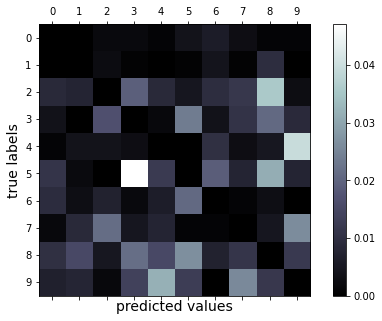

In [15]:
# normalize the diagonal cells so that they don't overpower the rest of the cells when visualized
import matplotlib.pyplot as plt

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx, cmap=plt.cm.bone)
ticks = np.arange(0, 10, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)
fig.colorbar(cax)
plt.ylabel('true labels', fontsize=14)
plt.xlabel('predicted values', fontsize=14)
plt.savefig('conf.png')
plt.show()

### Show predictions

Test the deployed model with a random sample of 30 images from the test data.

Print the returned predictions and plot them along with the input images. Red font and inverse image (white on black) is used to highlight the misclassified samples.
Since the model accuracy is high, you might have to run the following code a few times before you can see a misclassified sample.

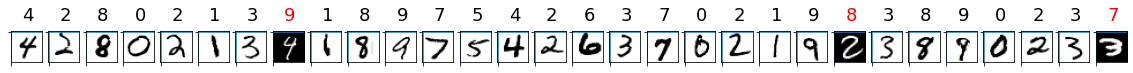

In [16]:
import json

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y=-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

### Delete the newly created cluster

Note: This is important if you wish to avoid the cost of this cluster

In [17]:
if is_new_compute:
    aks_target.delete()
    service.delete()